In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from scipy import stats

import html
import urllib

#from helper_functions import *

In [3]:
#data_path = './data/wikispeedia_paths-and-graph/'
data_path = ""

In [4]:
def read_tsv(file_name, names=None):
    
    file_path = data_path + f'{file_name}.tsv'
    
    if not names:
        with open(file_path, 'r') as file:
            for line in file:
                if 'FORMAT' in line:
                    format_line = line
                    break

        names = format_line.split()[2:]
    
    return pd.read_csv(file_path,
                           delimiter='\t', comment='#', header=0, names=names)

In [5]:
link_network = read_tsv('links', names=['source', 'target'])
categories = read_tsv('categories')
finished_paths = read_tsv('paths_finished')
unfinished_paths = read_tsv('paths_unfinished')
articles = read_tsv('articles')

In [6]:
categories[['category_1', 'category_2', 'category_3']] = \
                                categories['category'].str.replace(
                                    'subject.', '', n=1).str.split('.', expand=True)

First research question: Do the existing categories in this abridged Wikipedia reflect optimal shortest paths and/or the path effectively taken by players?

In [7]:
# create a directed graph

G_link = nx.from_pandas_edgelist(link_network, 'source', 'target', create_using=nx.DiGraph())


In [8]:
overall_nodes = G_link.number_of_nodes()
overall_edges = G_link.number_of_edges()

overall_strong_connect = nx.is_strongly_connected(G_link)
overall_weak_connect = nx.is_weakly_connected(G_link)

print(f"Number of nodes: {overall_nodes}")
print(f"Number of edges: {overall_edges}")

# reachable from any node to any node
print(f"Strongly connected? {'Yes' if overall_strong_connect else 'No'}")
# all nodes connected regardless of direction
print(f"Weakly connected? {'Yes' if overall_weak_connect else 'No'}") 

# degree Distribution
degrees = [G_link.degree(n) for n in G_link.nodes()]
overall_avg_deg = sum(degrees) / len(degrees)
print(f"Average degree: {overall_avg_deg}")


# clustering coefficient
overall_density = nx.density(G_link)
overall_avg_cc = nx.average_clustering(G_link)
print(f"Graph density: {overall_density}")
print(f"Average clustering coefficient: {overall_avg_cc}")

Number of nodes: 4594
Number of edges: 119883
Strongly connected? No
Weakly connected? No
Average degree: 52.19111885067479
Graph density: 0.005681593604471456
Average clustering coefficient: 0.1953649822005169


/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


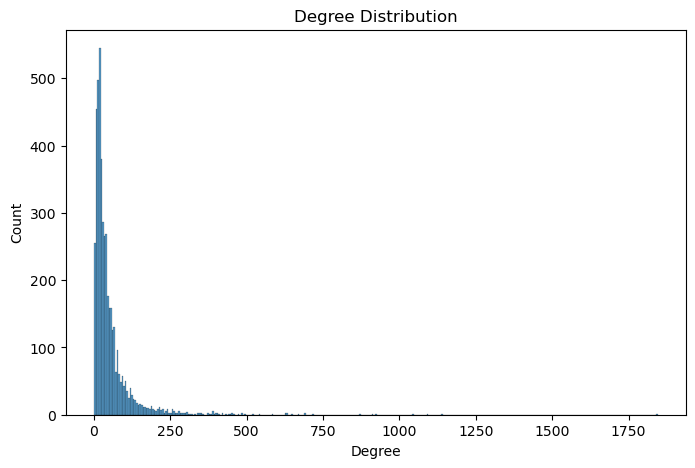

In [9]:
degrees = [G_link.degree(n) for n in G_link.nodes()]
plt.figure(figsize=(8, 5))
sns.histplot(degrees)  # Adjust the number of bins as needed
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()


- Articles are not all connected to each other.
- The average clustering coefficient indicates a moderately clustered network (considering the size).

In [10]:
# Get unique categories from 'category_1'
unique_categories = categories['category_1'].unique()
category_data = pd.DataFrame(columns=['category', 'nodes', 'edges',
                                      'avg_degree', 'density', 'clustering_coefficient',
                                     'strongly_connected', 'weakly_connected'])

category_data = category_data._append({
        'category': 'Overall/Average', 
        'nodes': overall_nodes, 
        'edges': overall_edges, 
        'avg_degree': overall_avg_deg/2, 
        'density': overall_density, 
        'clustering_coefficient': overall_avg_cc,
        'strongly_connected': overall_strong_connect,
        'weakly_connected': overall_weak_connect,
}, ignore_index=True)

# Iterate over each category and perform the analysis
for category in unique_categories:
    print(f"Analysis for Category: {category}")

    # Filter articles for the current category
    category_articles = categories[categories['category_1'] == category]['article']
    filtered_links = link_network[link_network['source'].isin(category_articles) & link_network['target'].isin(category_articles)]

    # Create a sub-network for the current category
    G_category = nx.from_pandas_edgelist(filtered_links, 'source', 'target', create_using=nx.DiGraph())

    # Perform analysis on the sub-network
    num_nodes = G_category.number_of_nodes()
    num_edges = G_category.number_of_edges()
    avg_degree = sum(dict(G_category.degree()).values()) / num_nodes if num_nodes > 0 else 0
    graph_density = nx.density(G_category)
    avg_clustering_coef = nx.average_clustering(G_category)
    
    strongly_connected = nx.is_strongly_connected(G_category)
    weakly_connected = nx.is_weakly_connected(G_category)
    
    category_data = category_data._append({
        'category': category, 
        'nodes': num_nodes, 
        'edges': num_edges, 
        'avg_degree': avg_degree/2, 
        'density': graph_density, 
        'clustering_coefficient': avg_clustering_coef,
        'strongly_connected': strongly_connected,
        'weakly_connected': weakly_connected,
    }, ignore_index=True)


    # Display the results
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Average degree/2: {avg_degree/2}")
    print(f"Graph density: {graph_density}")
    print(f"Average clustering coefficient: {avg_clustering_coef}")
    print(f"Strongly connected: {strongly_connected}")
    print(f"Weakly connected: {weakly_connected}")
    print("-" * 40)


/var/folders/1b/33gb2s092nb7fqf_f2b848yc0000gn/T/ipykernel_1603/481806457.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  category_data = category_data._append({


Analysis for Category: People
Number of nodes: 614
Number of edges: 3073
Average degree/2: 5.004885993485342
Graph density: 0.008164577477137589
Average clustering coefficient: 0.17848048741339442
Strongly connected: False
Weakly connected: False
----------------------------------------
Analysis for Category: Countries
Number of nodes: 229
Number of edges: 5523
Average degree/2: 24.117903930131003
Graph density: 0.10578028039531143
Average clustering coefficient: 0.4483423549677819
Strongly connected: False
Weakly connected: True
----------------------------------------
Analysis for Category: Geography
Number of nodes: 1061
Number of edges: 22570
Average degree/2: 21.272384542884073
Graph density: 0.020068287304607614
Average clustering coefficient: 0.296908274402231
Strongly connected: False
Weakly connected: True
----------------------------------------
Analysis for Category: History
Number of nodes: 494
Number of edges: 3870
Average degree/2: 7.834008097165992
Graph density: 0.01589

In [11]:
# compute averages
category_data.at[0, 'nodes'] = category_data.at[0, 'nodes'] / 15
category_data.at[0, 'edges'] = category_data.at[0, 'edges'] / 15

/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/timothymorvan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

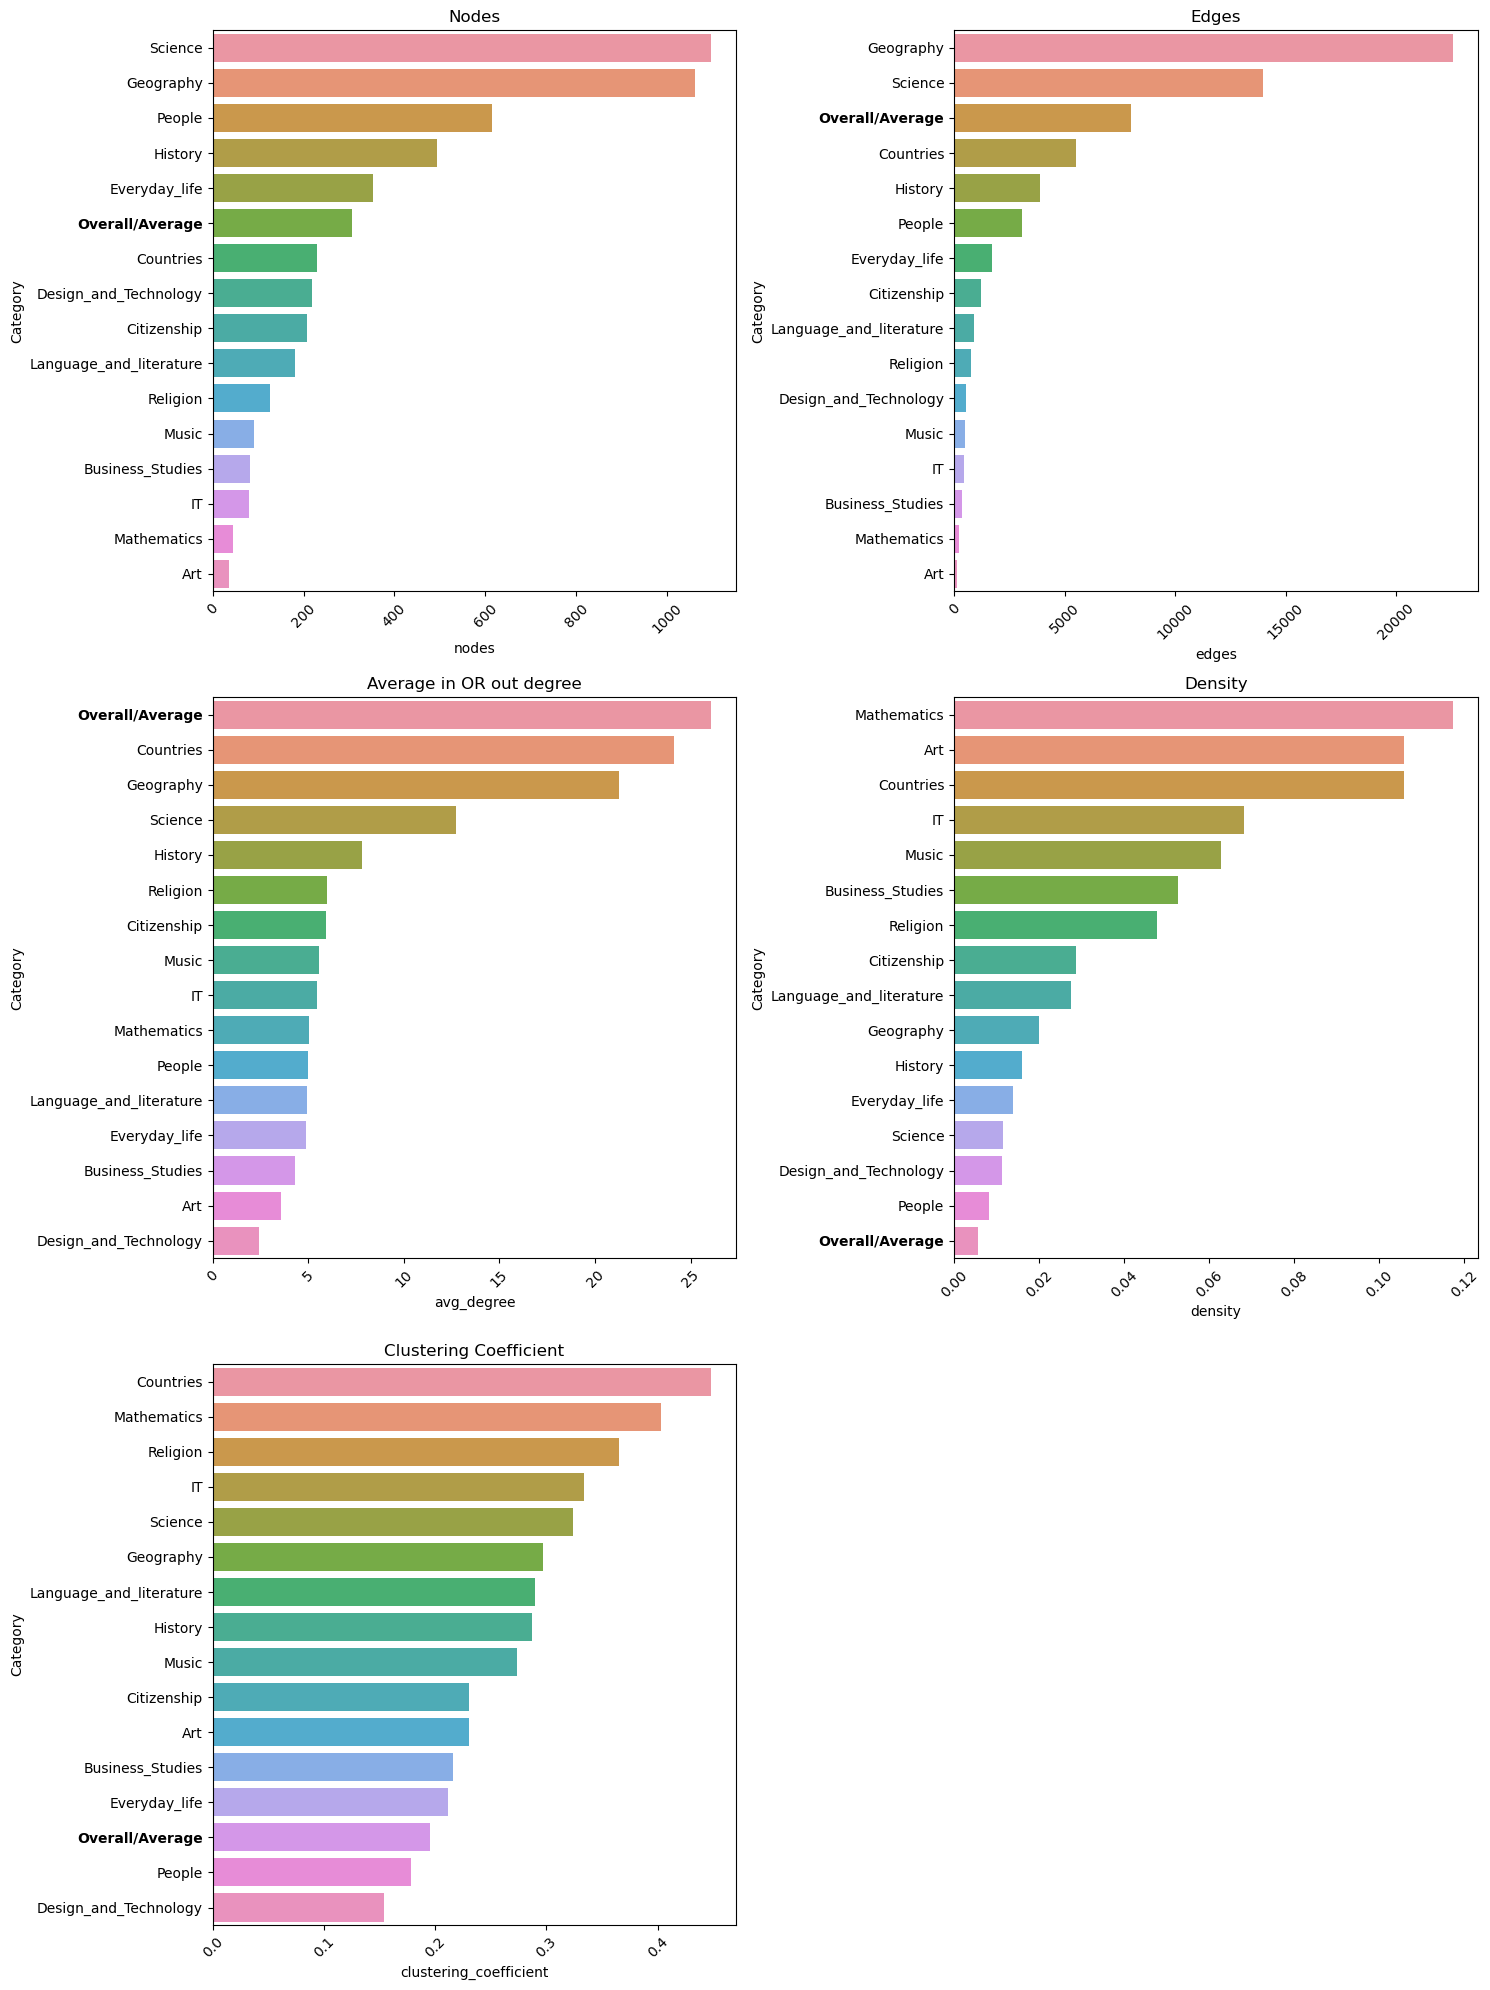

In [12]:

properties = ['nodes', 'edges', 'avg_degree', 'density', 'clustering_coefficient']

plt.figure(figsize=(15, 20))

for i, prop in enumerate(properties, 1):
    plt.subplot(3, 2, i)  
    sorted_data = category_data.sort_values(by=prop, ascending=False)
    sns.barplot(y='category', x=prop, data=sorted_data)
    for lab in plt.gca().get_yticklabels():
        if lab.get_text() == "Overall/Average":
            lab.set_fontweight('bold')
    
    title_txt = f'{prop.replace("_", " ").title()}'
    if prop == 'avg_degree': title_txt = 'Average in OR out degree'
    plt.title(title_txt)
    plt.ylabel('Category')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


- Within each category compared to overall: much higher graph density, usually higher avg clustering coefficients
- Some categories are more connected than others, or have more links, or more dense.
- In some categories, all articles are weakly connected.

In [79]:

file_path = data_path + 'shortest-path-distance-matrix.txt'

distance_matrix = []

with open(file_path, 'r') as file:
    for line in file:
        if line.startswith('#') or line.isspace():
            continue
        distances = [-1 if char == '_' else int(char) for char in line.strip()]
        distance_matrix.append(distances)

shortest_paths = pd.DataFrame(distance_matrix)



In [80]:
# Replace -1 and 0 with NaN
shortest_paths_replaced = shortest_paths.replace([-1, 0], None)

# Calculate the overall average shortest path length
total_distance = shortest_paths_replaced.sum().sum()
count_valid_distances = shortest_paths_replaced.count().sum()
overall_average_shortest_path = total_distance / count_valid_distances if count_valid_distances > 0 else None

print(f"Average shortest path length: {overall_average_shortest_path}")


Average shortest path length: 3.202522563331053


In [100]:

category_avg_path_lengths = {}
category_shortest_paths = {}

article_to_index = pd.Series(articles.index, index=articles['article']).to_dict()

def calculate_avg_shortest_path(filtered_shortest_paths):
    filtered_shortest_paths_replaced = filtered_shortest_paths.replace([-1, 0], np.nan)
    total_distance = np.nansum(filtered_shortest_paths_replaced.values)
    count_valid_distances = np.sum(~np.isnan(filtered_shortest_paths_replaced.values))
    return total_distance / count_valid_distances if count_valid_distances > 0 else None

for category in unique_categories:
    category_articles = categories[categories['category_1'] == category]['article']
    category_article_indices = [article_to_index[article] for article in category_articles if article in article_to_index]
    filtered_shortest_paths = shortest_paths.iloc[category_article_indices, category_article_indices]

    avg_shortest_path = calculate_avg_shortest_path(filtered_shortest_paths)
    category_avg_path_lengths[category] = avg_shortest_path

    valid_distances = filtered_shortest_paths.values[(filtered_shortest_paths != -1) & (filtered_shortest_paths != 0)]
    category_shortest_paths[category] = valid_distances

for category, avg_shortest_path in category_avg_path_lengths.items():
    print(f"Category: {category}, Average shortest path length: {avg_shortest_path}")

# Perform ANOVA using the shortest paths data
grouped_data = list(category_shortest_paths.values())
anova_result = stats.f_oneway(*grouped_data)
print(f"ANOVA F-statistic: {anova_result.statistic}, P-value: {anova_result.pvalue}")


Category: People, Average shortest path length: 3.1603989405846993
Category: Countries, Average shortest path length: 3.144965494304482
Category: Geography, Average shortest path length: 3.2149226810807074
Category: History, Average shortest path length: 3.0724539555877968
Category: Business_Studies, Average shortest path length: 3.1384332362409935
Category: Science, Average shortest path length: 3.25707298928542
Category: Everyday_life, Average shortest path length: 3.180583118343587
Category: Design_and_Technology, Average shortest path length: 3.130738684347654
Category: Music, Average shortest path length: 3.272845643939394
Category: IT, Average shortest path length: 3.2758502232909654
Category: Language_and_literature, Average shortest path length: 3.246640497406951
Category: Mathematics, Average shortest path length: 3.291267942583732
Category: Religion, Average shortest path length: 3.0906029402240787
Category: Art, Average shortest path length: 3.0286650286650287
Category: Citi

In [115]:
pd.DataFrame(category_avg_path_lengths.items(), columns=['category', 'avg_spl']).describe()

,avg_spl
count,15.000000
mean,3.175591
std,0.081234
min,3.028665
25%,3.129579
50%,3.160399
75%,3.251857
max,3.291268


The existing categorization does reduce the average shortest distance in many categories, and is overall statistically
siginificant.

In [205]:
finished_paths['finished'] = 1
finished_paths['target'] = finished_paths['path'].apply(lambda x: x.split(';')[-1])

unfinished_paths['finished'] = 0

all_paths = pd.concat([finished_paths, unfinished_paths], ignore_index=True, sort=False)

all_paths['path'] = all_paths['path'].apply(lambda x: x.split(';'))
all_paths['start'] = all_paths['path'].apply(lambda x: x[0])

In [219]:
filtered_paths = all_paths[~all_paths['path'].str.contains('<', regex=False)]

In [237]:
article_to_categories = categories.groupby('article')['category_1'].apply(list).to_dict()

def have_common_category(start, target):
    start_categories = set(article_to_categories.get(start, []))
    target_categories = set(article_to_categories.get(target, []))
    return int(len(start_categories.intersection(target_categories)) > 0)

filtered_paths.loc[:, 'same_category'] = filtered_paths.apply(
    lambda row: have_common_category(row['start'], row['target']), axis=1)


In [238]:
filtered_paths

,hashedIpAddress,timestamp,durationInSec,path,rating,finished,target,type,start,same_category
0,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,1,African_slave_trade,NaN,14th_century,1
1,415612e93584d30e,1349298640,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,1,African_slave_trade,NaN,14th_century,1
2,64dd5cd342e3780c,1265613925,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,1,Greece,NaN,14th_century,0
3,015245d773376aab,1366730828,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,1,John_F._Kennedy,NaN,14th_century,0
4,5295bca242be81fe,1372890414,110,"[14th_century, Europe, North_America, United_S...",NaN,1,John_F._Kennedy,NaN,14th_century,0
...,...,...,...,...,...,...,...,...,...,...
76184,109ed71f571d86e9,1389785768,72,"[Wine, Georgia_%28country%29, Russia]",NaN,0,History_of_post-Soviet_Russia,restart,Wine,0
76185,109ed71f571d86e9,1389787212,182,"[Turks_and_Caicos_Islands, United_States, Iraq...",NaN,0,Iraq_War,restart,Turks_and_Caicos_Islands,0
76187,232f992e57d43e8d,1389787697,6,[Modern_history],NaN,0,Hollandic,restart,Modern_history,0
76189,60af9e2138051b96,1389799481,1903,"[Jamaica, United_Kingdom, World_War_II, Battle...",NaN,0,Alan_Turing,timeout,Jamaica,0


In [239]:
model = smf.ols(formula='rating ~ same_category',
                data=filtered_paths)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     111.6
Date:                Sun, 17 Dec 2023   Prob (F-statistic):           5.02e-26
Time:                        19:39:06   Log-Likelihood:                -34835.
No. Observations:               23566   AIC:                         6.967e+04
Df Residuals:                   23564   BIC:                         6.969e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.1824      0.008    285.616

In [241]:
model = smf.ols(formula='durationInSec ~ same_category',
                data=filtered_paths[filtered_paths['finished'] == 1])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          durationInSec   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     45.19
Date:                Sun, 17 Dec 2023   Prob (F-statistic):           1.81e-11
Time:                        22:29:03   Log-Likelihood:            -3.0981e+05
No. Observations:               42322   AIC:                         6.196e+05
Df Residuals:                   42320   BIC:                         6.196e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       140.2648      1.961     71.540

## How do different network centrality and clustering measures affect player paths and can it give us insight into the way humans perceive and utilize hubs in an information network?


In [269]:
weighted_graph = nx.DiGraph()
edge_weights = {}

for _, row in filtered_paths[filtered_paths.finished == 1].iterrows():
    path = row['path']

    for i in range(len(path) - 1):
        source = path[i]
        target = path[i + 1]

        if not weighted_graph.has_edge(source, target):
            weighted_graph.add_edge(source, target, weight=1)
            edge_weights[(source, target)] = 1
        else:
            edge_weights[(source, target)] += 1
            weighted_graph[source][target]['weight'] = edge_weights[(source, target)]

num_nodes_weighted = len(weighted_graph.nodes)
num_edges_weighted = len(weighted_graph.edges)

print(f"Weighted Graph: {num_nodes_weighted} nodes, {num_edges_weighted} edges")


Weighted Graph: 4156 nodes, 44907 edges


In [270]:
num_nodes = weighted_graph.number_of_nodes()
num_edges = weighted_graph.number_of_edges()

weighted_avg_degree = sum(d for n, d in weighted_graph.degree(weight='weight')) / num_nodes if num_nodes > 0 else 0

graph_density = nx.density(weighted_graph)
avg_clustering_coef = nx.average_clustering(weighted_graph)

strongly_connected = nx.is_strongly_connected(weighted_graph)
weakly_connected = nx.is_weakly_connected(weighted_graph)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average weighted degree: {weighted_avg_degree}")
print(f"Graph density: {graph_density}")
print(f"Average clustering coefficient: {avg_clustering_coef}")
print(f"Strongly connected: {strongly_connected}")
print(f"Weakly connected: {weakly_connected}")


Number of nodes: 4156
Number of edges: 44907
Average weighted degree: 96.21607314725698
Graph density: 0.0026005635799487845
Average clustering coefficient: 0.196391165775825
Strongly connected: False
Weakly connected: True


In [271]:
# Create an unweighted graph
unweighted_graph = weighted_graph.copy()
for u, v, data in unweighted_graph.edges(data=True):
    data['weight'] = 1  
unweighted_degree = dict(unweighted_graph.degree())

# Calculate the average unweighted degree
average_unweighted_degree = sum(unweighted_degree.values()) / len(unweighted_degree)

print(f"Average Unweighted Degree: {average_unweighted_degree}")


Average Unweighted Degree: 21.610683349374398


- Weighted degree >> unweighted: some articles are used as hubs?

In [302]:

degrees = dict(weighted_graph.degree(weighted_graph.nodes()))
top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:200]
subgraph = unweighted_graph.subgraph(top_nodes)

layout = nx.spring_layout(subgraph)

#plt.figure(figsize=(12, 10))
#nx.draw(subgraph, pos=layout, with_labels=True, node_size=200, node_color='lightblue', font_size=10)
#plt.title("Top 100 Articles with Highest Degrees in Weighted Graph")
#plt.show()


In [309]:


degree_centrality = nx.degree_centrality(subgraph)
betweenness_centrality = nx.betweenness_centrality(subgraph)
closeness_centrality = nx.closeness_centrality(subgraph)
eigenvector_centrality = nx.eigenvector_centrality(subgraph)


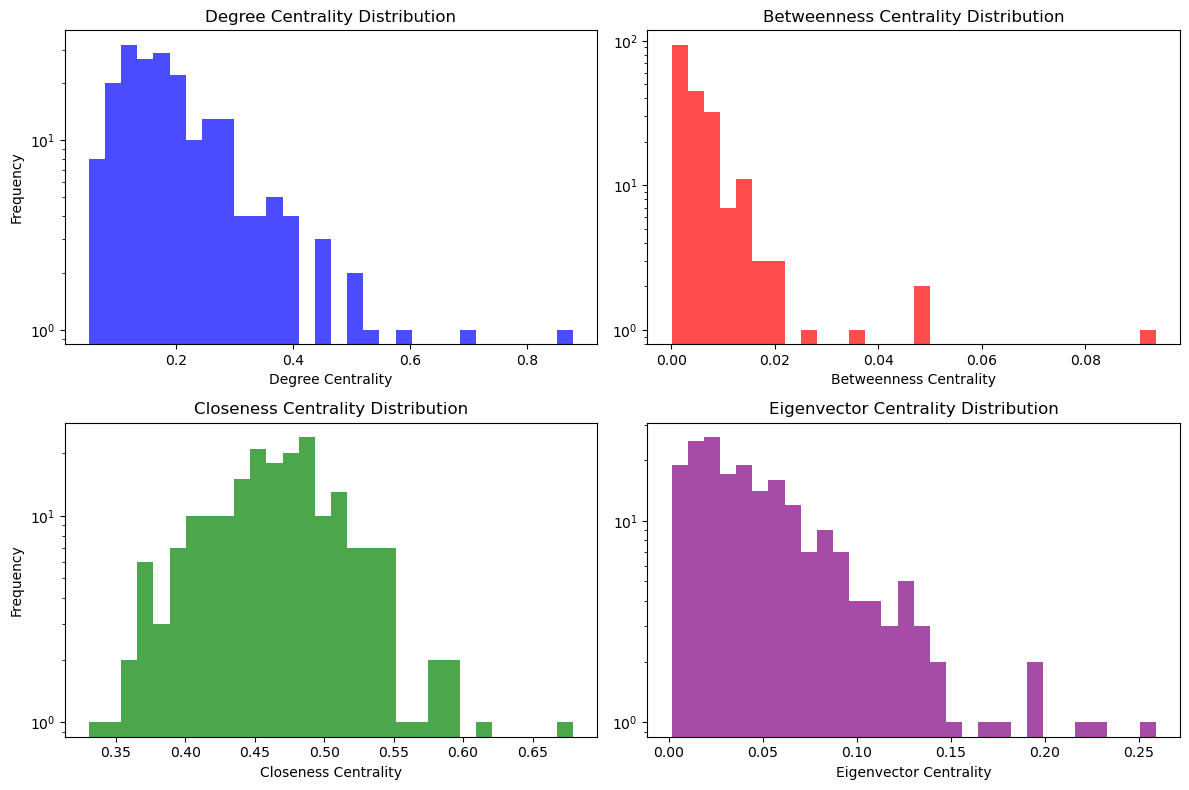

In [310]:
degree_centrality_values = list(degree_centrality.values())
betweenness_centrality_values = list(betweenness_centrality.values())
closeness_centrality_values = list(closeness_centrality.values())
eigenvector_centrality_values = list(eigenvector_centrality.values())

plt.figure(figsize=(12, 8))

# Degree distribution
plt.subplot(2, 2, 1)
plt.hist(degree_centrality_values, bins=30, color='blue', alpha=0.7, log=True)
plt.title('Degree Centrality Distribution')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')

# Betweenness distribution
plt.subplot(2, 2, 2)
plt.hist(betweenness_centrality_values, bins=30, color='red', alpha=0.7, log=True)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')

# Closeness distribution
plt.subplot(2, 2, 3)
plt.hist(closeness_centrality_values, bins=30, color='green', alpha=0.7, log=True)
plt.title('Closeness Centrality Distribution')
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')

# Eigenvector distribution
plt.subplot(2, 2, 4)
plt.hist(eigenvector_centrality_values, bins=30, color='purple', alpha=0.7, log=True)
plt.title('Eigenvector Centrality Distribution')
plt.xlabel('Eigenvector Centrality')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [314]:
mean_degree_centrality = np.mean(degree_centrality_values)
median_degree_centrality = np.median(degree_centrality_values)

mean_betweenness_centrality = np.mean(betweenness_centrality_values)
median_betweenness_centrality = np.median(betweenness_centrality_values)

mean_closeness_centrality = np.mean(closeness_centrality_values)
median_closeness_centrality = np.median(closeness_centrality_values)

mean_eigenvector_centrality = np.mean(eigenvector_centrality_values)
median_eigenvector_centrality = np.median(eigenvector_centrality_values)

print("Mean Degree Centrality:", mean_degree_centrality)
print("Median Degree Centrality:", median_degree_centrality)

print("Mean Betweenness Centrality:", mean_betweenness_centrality)
print("Median Betweenness Centrality:", median_betweenness_centrality)

print("Mean Closeness Centrality:", mean_closeness_centrality)
print("Median Closeness Centrality:", median_closeness_centrality)

print("Mean Eigenvector Centrality:", mean_eigenvector_centrality)
print("Median Eigenvector Centrality:", median_eigenvector_centrality)

Mean Degree Centrality: 0.1996482412060301
Median Degree Centrality: 0.1708542713567839
Mean Betweenness Centrality: 0.005914166793563777
Median Betweenness Centrality: 0.003652563117303032
Mean Closeness Centrality: 0.4664186554753161
Median Closeness Centrality: 0.46604215456674475
Mean Eigenvector Centrality: 0.054112891113381995
Median Eigenvector Centrality: 0.041678591063635764


In [306]:


all_degree_centrality = nx.degree_centrality(unweighted_graph)
all_betweenness_centrality = nx.betweenness_centrality(unweighted_graph)
all_closeness_centrality = nx.closeness_centrality(unweighted_graph)
all_eigenvector_centrality = nx.eigenvector_centrality(unweighted_graph)


In [316]:
mean_degree_centrality = np.mean(degree_centrality_values)
median_degree_centrality = np.median(degree_centrality_values)

mean_betweenness_centrality = np.mean(betweenness_centrality_values)
median_betweenness_centrality = np.median(betweenness_centrality_values)

mean_closeness_centrality = np.mean(closeness_centrality_values)
median_closeness_centrality = np.median(closeness_centrality_values)

mean_eigenvector_centrality = np.mean(eigenvector_centrality_values)
median_eigenvector_centrality = np.median(eigenvector_centrality_values)

print("Mean Degree Centrality:", mean_degree_centrality)
print("Median Degree Centrality:", median_degree_centrality)

print("Mean Betweenness Centrality:", mean_betweenness_centrality)
print("Median Betweenness Centrality:", median_betweenness_centrality)

print("Mean Closeness Centrality:", mean_closeness_centrality)
print("Median Closeness Centrality:", median_closeness_centrality)

print("Mean Eigenvector Centrality:", mean_eigenvector_centrality)
print("Median Eigenvector Centrality:", median_eigenvector_centrality)

Mean Degree Centrality: 0.005201127159897568
Median Degree Centrality: 0.0024067388688327317
Mean Betweenness Centrality: 0.0005148503854228296
Median Betweenness Centrality: 3.794312226603417e-05
Mean Closeness Centrality: 0.25742518454170277
Median Closeness Centrality: 0.28401710643988665
Mean Eigenvector Centrality: 0.005739499204835266
Median Eigenvector Centrality: 0.001250712017052214


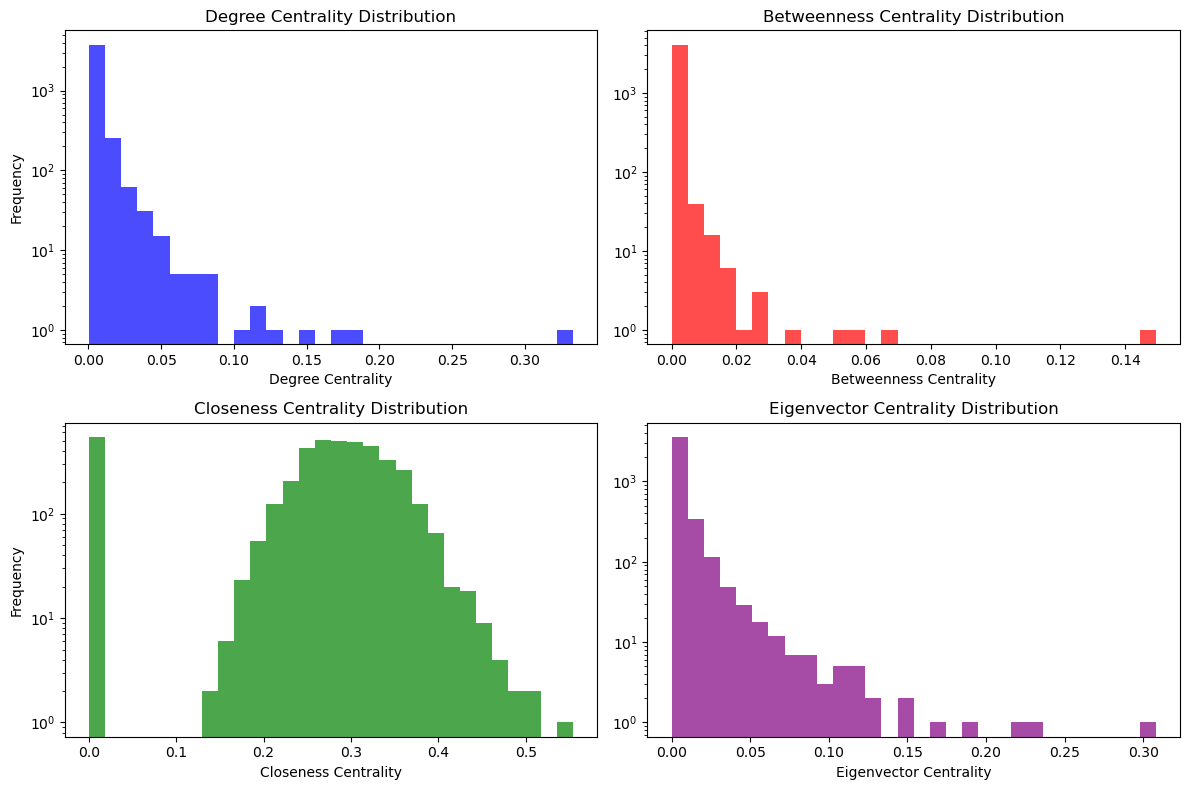

In [315]:
degree_centrality_values = list(all_degree_centrality.values())
betweenness_centrality_values = list(all_betweenness_centrality.values())
closeness_centrality_values = list(all_closeness_centrality.values())
eigenvector_centrality_values = list(all_eigenvector_centrality.values())

plt.figure(figsize=(12, 8))

# Degree distribution
plt.subplot(2, 2, 1)
plt.hist(degree_centrality_values, bins=30, color='blue', alpha=0.7, log=True)
plt.title('Degree Centrality Distribution')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')

# Betweenness distribution
plt.subplot(2, 2, 2)
plt.hist(betweenness_centrality_values, bins=30, color='red', alpha=0.7, log=True)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')

# Closeness distribution
plt.subplot(2, 2, 3)
plt.hist(closeness_centrality_values, bins=30, color='green', alpha=0.7, log=True)
plt.title('Closeness Centrality Distribution')
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')

# Eigenvector distribution
plt.subplot(2, 2, 4)
plt.hist(eigenvector_centrality_values, bins=30, color='purple', alpha=0.7, log=True)
plt.title('Eigenvector Centrality Distribution')
plt.xlabel('Eigenvector Centrality')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [317]:

category_counts = categories.groupby('article')['category_1'].count()

# Calculate the average number of categories per article
average_categories_per_article = category_counts.mean()

print(f"Average number of categories per article: {average_categories_per_article:.2f}")


Average number of categories per article: 1.13


In [318]:
filtered_categories = categories[categories['article'].isin(top_nodes)]
category_counts = filtered_categories.groupby('article')['category_1'].count()
average_categories_per_top_nodes = category_counts.mean()

print(f"Average number of categories per article for top_nodes: {average_categories_per_top_nodes:.2f}")


Average number of categories per article for top_nodes: 1.28
